In [17]:
%matplotlib inline 

import numpy as np
import pandas as pd
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

# import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import matplotlib.patheffects as PathEffects

import warnings; warnings.simplefilter('ignore') #not the best, but helps when zeros are out of hand

In [2]:
# fontsize, linewidth, etc.
fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20

## Import data

In [3]:
# fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow_20m.nc' #ARS
fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' #BSU
#~~~~ ds full
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds['snow'] = ds.snow/10 #convert to cm
ds['snow'] = ds.snow.where(ds.snow>0) #all snow > zero
ds.close()

#~~~~ ds peak
dpeak = ds.isel(time=[0,7,18,30,42,49]) #0,7,22,28,41,49]
dpeak.close()

ds = dpeak
ds.close()

In [4]:
# legends/labels
d_str = pd.to_datetime(ds['time'].values).strftime("%Y-%m-%d")
print('number of legend labels:', len(d_str))
print(d_str[0][:4])

number of legend labels: 6
2013


## one-to-one for ONE

In [ ]:
def one_to_one(lidar_date_str_1, lidar_date_str_2):
     
    '''    
    flatten lidar
    '''
    #lidar_1
    s1 = ds.snow.sel(time=lidar_date_str_1).values.flatten()
    s1_gt_zero = s1 > 0
    
    #lidar_2
    s2 = ds.snow.sel(time=lidar_date_str_2).values.flatten()
    s2_gt_zero = s2 > 0
    
    '''
    scatter plot
    '''
    #scatter
    ax = plt.scatter(s2[s1_gt_zero & s2_gt_zero][::100] / np.nanmean(s2[s2_gt_zero]),
            s1[s1_gt_zero & s2_gt_zero][::100] / np.nanmean(s1[s1_gt_zero]), 
                     color='cornflowerblue', 
                     alpha=0.01) #[:1000000][:1000000]
    
    #blackline 1-to-1 line
    plt.plot([0, 10], [0, 10], '-k', linewidth = 2)
    
    #plot formatting
    plt.xlim(0,10); plt.ylim(0,10)
#     plt.xlabel('{}'.format(lidar_date_str_2[:4]), fontsize=fs_axes)
#     plt.ylabel('{}'.format(lidar_date_str_1[:4]), fontsize=fs_axes)
    plt.xticks(fontsize=fs_axes-6)
    plt.yticks(fontsize=fs_axes-6)
    
    '''
    text stats on plot
    '''
    # title
    txt_title = plt.annotate('{} vs {}'.
                            format(lidar_date_str_1[:4], 
                                   lidar_date_str_2[:4]), 
                            xy=(0.5,9), fontsize=fs_labels+4)
    # mean w/o zeros
    txt_mean = plt.annotate('$\mu$: {:.0f} vs. {:.0f} cm'.
                            format(np.nanmean(s1[s1_gt_zero]/10), 
                                   np.nanmean(s2[s2_gt_zero]/10)), 
                            xy=(0.5,8), fontsize=fs_labels)
    #R2 value
    r_squared = pearsonr(s2[s1_gt_zero & s2_gt_zero] / np.nanmean(s2[s2_gt_zero]),
                         s1[s1_gt_zero & s2_gt_zero] / np.nanmean(s1[s1_gt_zero]))
    txt_r_squared = plt.annotate('$R^2$: {:.3f}'.format(r_squared[0]),
                                 xy=(0.5,7), fontsize=fs_labels)
    
    return lidar_date_str_1[:4],lidar_date_str_2[:4]

In [ ]:
t=time.time()

plt.figure(figsize=(6,6))
l1,l2 = one_to_one('2013-04-03', '2017-04-01')
# plt.savefig('../figs/one2one_{}_vs_{}'.format(l1,l2), dpi=300)


tt=time.time()
print('runtime =', (tt-t)/60)

## subplot version

In [ ]:
# ~~~~~~~plt.scatter()

# Create matrix with indices
num=6 #5
num_2=5 #4
#plotting matrix:
index_matrix = np.zeros((num,num), dtype = int)
k_index = 1
for i_row in range(num):
    for i_column in range(num):
        index_matrix[i_row, i_column] = k_index
        k_index += 1
print(index_matrix)

#loop to plot
plt.figure(figsize = (20, 20))

for i_year in range(num_2):
    
    #lidar_1
    s1 = ds.snow.sel(time=d_str[i_year]).values.flatten()
    s1_gt_zero = s1 > 0

    for i_year_2 in range(i_year + 1, num):
        #lidar_2
        s2 = ds.snow.sel(time=d_str[i_year_2]).values.flatten()
        s2_gt_zero = s2 > 0

        '''
        scatter plot
        '''
        #scatter
        ax = plt.subplot(num, num, index_matrix[i_year, i_year_2])
        ax = plt.scatter(s2[s1_gt_zero & s2_gt_zero][::100] / np.nanmean(s2[s2_gt_zero]),
                s1[s1_gt_zero & s2_gt_zero][::100] / np.nanmean(s1[s1_gt_zero]), 
                         color='cornflowerblue', 
                         alpha=0.01) #[:1000000][:1000000]

        #blackline 1-to-1 line
        plt.plot([0, 10], [0, 10], '-k', linewidth = 2)

        #plot formatting
        plt.xlim(0,10); plt.ylim(0,10)
        plt.xticks(fontsize=fs_axes-6)
        plt.yticks(fontsize=fs_axes-6)

        '''
        text stats on plot
        '''
        # title
        txt_title = plt.annotate('{} vs. {}'.
                                format(d_str[i_year][:4], 
                                       d_str[i_year_2][:4]), 
                                xy=(0.5,8.8), fontsize=fs_labels-6)
        txt_title.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        
        # mean w/o zeros
        txt_mean = plt.annotate('$\mu$: {:.0f} vs. {:.0f} cm'.
                                format(np.nanmean(s1[s1_gt_zero]/10), 
                                       np.nanmean(s2[s2_gt_zero]/10)), 
                                xy=(0.5,7.8), fontsize=fs_labels-9)
        txt_mean.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

        #R2 value
        r_squared = pearsonr(s2[s1_gt_zero & s2_gt_zero] / np.nanmean(s2[s2_gt_zero]),
                             s1[s1_gt_zero & s2_gt_zero] / np.nanmean(s1[s1_gt_zero]))
        txt_r_squared = plt.annotate('$R^2$: {:.3f}'.format(r_squared[0]),
                                     xy=(0.5,6.6), fontsize=fs_labels-9)
        txt_r_squared.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        
# plt.savefig('../figs/one2one_subplots_6yrs')#, dpi=300)
#5yr: use fs_lables-2 and fs_labels-6
#6yr: use fs_lables-5 and fs_labels-9

In [ ]:
# ~~~~~~~plt.hexbin()

# Create matrix with indices
num=6 #5
num_2=5 #4
#plotting matrix:
index_matrix = np.zeros((num,num), dtype = int)
k_index = 1
for i_row in range(num):
    for i_column in range(num):
        index_matrix[i_row, i_column] = k_index
        k_index += 1
print(index_matrix)

#loop to plot
fig = plt.figure(figsize = (20, 20))

for i_year in range(num_2):
    
    #lidar_1
    s1 = ds.snow.sel(time=d_str[i_year]).values.flatten()
    s1_gt_zero = s1 > 0

    for i_year_2 in range(i_year + 1, num):
        #lidar_2
        s2 = ds.snow.sel(time=d_str[i_year_2]).values.flatten()
        s2_gt_zero = s2 > 0

        '''
        hexbin plot
        '''
        #scatter
        ax = plt.subplot(num, num, index_matrix[i_year, i_year_2])
        
        ax = plt.hexbin(s2[s1_gt_zero & s2_gt_zero] / np.nanmean(s2[s2_gt_zero]), 
                        s1[s1_gt_zero & s2_gt_zero] / np.nanmean(s1[s1_gt_zero]), 
                        mincnt=10, bins=1000, vmin = 0, vmax = 500)
#         plt.colorbar()
#         print(p.get_array())

        #blackline 1-to-1 line
        plt.plot([0, 10], [0, 10], '-k', linewidth = 2)

        #plot formatting
#         plt.yticks([5,10,15])
        plt.xlim(0,10); plt.ylim(0,10)
        plt.xticks(fontsize=fs_axes-6)
        plt.yticks(fontsize=fs_axes-6)

        '''
        text stats on plot
        '''
        # title
        txt_title = plt.annotate('{} vs. {}'.
                                format(d_str[i_year][:4], 
                                       d_str[i_year_2][:4]), 
                                xy=(0.5,8.8), fontsize=fs_labels-8)
        txt_title.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        
        # mean w/o zeros
        txt_mean = plt.annotate('$\mu$: {:.0f} vs. {:.0f} cm'.
                                format(np.nanmean(s1[s1_gt_zero]/10), 
                                       np.nanmean(s2[s2_gt_zero]/10)), 
                                xy=(0.5,7.7), fontsize=fs_labels-9)
        txt_mean.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

        #R2 value
        r_squared = pearsonr(s2[s1_gt_zero & s2_gt_zero] / np.nanmean(s2[s2_gt_zero]),
                             s1[s1_gt_zero & s2_gt_zero] / np.nanmean(s1[s1_gt_zero]))
        txt_r_squared = plt.annotate('$R^2$: {:.3f}'.format(r_squared[0]),
                                     xy=(0.5,6.6), fontsize=fs_labels-9)
        txt_r_squared.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        
        
# plt.colorbar()
cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8])  # This is the position for the colorbar
cb = plt.colorbar(ax, cax = cbaxes)

# plt.savefig('../figs/one2one_subplots_6yrs_hexbins')#, dpi=300)

### C/P above, and changed April 2020

In [5]:
ds

<xarray.Dataset>
Dimensions:  (time: 6, x: 2637, y: 2739)
Coordinates:
  * x        (x) float32 254000.0 254020.0 254040.0 ... 306700.0 306720.0
  * y        (y) float32 4234060.0 4234040.0 4234020.0 ... 4179320.0 4179300.0
  * time     (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    snow     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

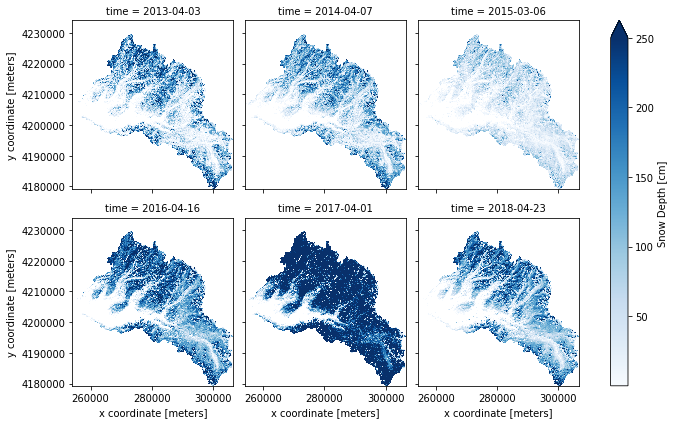

In [6]:
ds.snow.plot.imshow(x='x', y='y', col='time', col_wrap=3, cmap='Blues', vmax=250, cbar_kwargs={'label': 'Snow Depth [cm]'})

In [7]:
#standardize
stan = (ds.snow - ds.snow.mean(dim=('x','y'))) / ds.snow.std(dim=('x','y'))
stan

<xarray.DataArray 'snow' (time: 6, y: 2739, x: 2637)>
dask.array<truediv, shape=(6, 2739, 2637), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 254000.0 254020.0 254040.0 ... 306700.0 306720.0
  * y        (y) float32 4234060.0 4234040.0 4234020.0 ... 4179320.0 4179300.0
  * time     (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>

In [9]:
stan_df = stan.to_dataframe().dropna(how='any')
stan_df

In [ ]:
stan_ = stan_df.to_xarray()
stan_

//anaconda3/envs/data_analysis/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value 

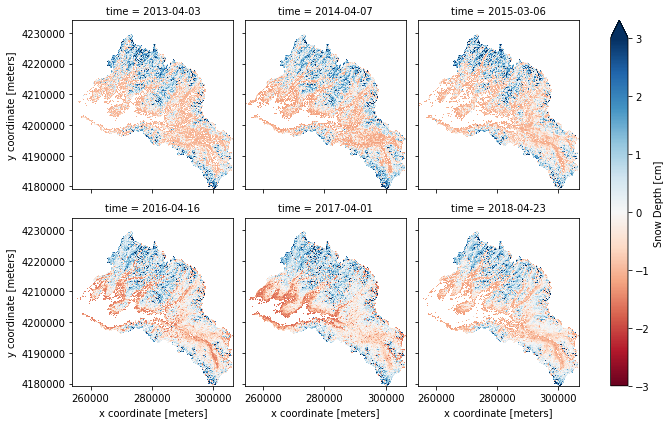

In [10]:
stan.plot.imshow(x='x', y='y', col='time', col_wrap=3, cmap='RdBu', vmin=-3, vmax=3, cbar_kwargs={'label': 'Snow Depth [cm]'})

In [ ]:
d = ds.isel(x=slice(2100,2600), y=slice(2000,2500))
d.snow.plot.imshow(x='x', y='y', col='time', vmax=250)

In [ ]:
#standardize
stan = (d.snow - d.snow.mean(dim=('x','y'))) / d.snow.std(dim=('x','y'))
stan

In [ ]:

# # stan.isel(time=3).mean().values
# print(d.snow.mean(dim=('x','y')).values)
# print(d.snow.std(dim=('x','y')).values)

# print(d.snow.isel(time=0).values)
# print(stan.isel(time=0).values)

[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]
 [13 14 15 16 17 18]
 [19 20 21 22 23 24]
 [25 26 27 28 29 30]
 [31 32 33 34 35 36]]


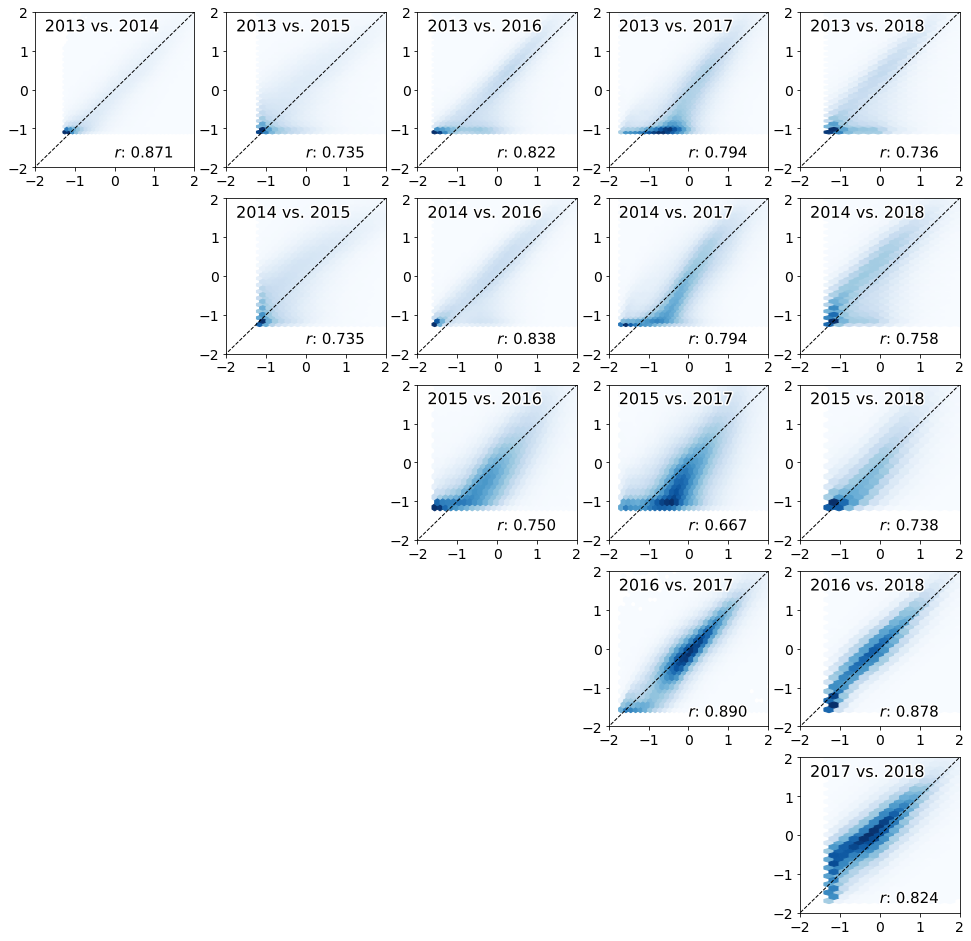

In [36]:
# *******NEW*******  ~~~~~~~plt.hexbin()

# Create matrix with indices
num=6 #5
num_2=5 #4
#plotting matrix:
index_matrix = np.zeros((num,num), dtype = int)
k_index = 1
for i_row in range(num):
    for i_column in range(num):
        index_matrix[i_row, i_column] = k_index
        k_index += 1
print(index_matrix)
#loop to plot
fig = plt.figure(figsize = (20, 20))

for i_year in range(num_2):
    
    #lidar_1
    s1 = stan.sel(time=d_str[i_year]).values.flatten()
    

    
    for i_year_2 in range(i_year + 1, num):
        #lidar_2
        s2 = stan.sel(time=d_str[i_year_2]).values.flatten()
        

        '''
        hexbin plot
        '''
    
        ax = plt.subplot(num, num, index_matrix[i_year, i_year_2])

        ax = plt.hexbin(s2, s1, cmap='Blues', mincnt=1, bins=10000)

        #black dotted 1-to-1 line
        plt.plot([-3, 3], [-3, 3], '--k', linewidth = 1)

        #plot formatting
#         plt.yticks([5,10,15])
        plt.xlim(-2,2); plt.ylim(-2,2)
        plt.xticks(fontsize=fs_axes-6)
        plt.yticks(fontsize=fs_axes-6)
#         plt.xlabel()
#         plt.ylabel()

#         '''
#         text stats on plot
#         '''
#         # title
        txt_title = plt.annotate('{} vs. {}'.
                                 format(d_str[i_year][:4], 
                                        d_str[i_year_2][:4]), 
                                 xy=(-1.75,1.5), fontsize=fs_labels-8)
        txt_title.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        
        #r value
        ix = ~np.isnan(s2) & ~np.isnan(s1)
        r = pearsonr(s2[ix], s1[ix]) 
        txt_r = plt.annotate('$r$: {:.3f}'.format(r[0]),
                                     xy=(0,-1.75), fontsize=fs_labels-9)
        txt_r.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        
#         if in
        
        
# # plt.colorbar()
# cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8])  # This is the position for the colorbar
# cb = plt.colorbar(ax, cax = cbaxes)

# # plt.savefig('../figs/one2one_subplots_6yrs_hexbins')#, dpi=300)
plt.show()

In [ ]:
# ~~~~~~~plt.2dhist()

# Create matrix with indices
num=6 #5
num_2=5 #4
#plotting matrix:
index_matrix = np.zeros((num,num), dtype = int)
k_index = 1
for i_row in range(num):
    for i_column in range(num):
        index_matrix[i_row, i_column] = k_index
        k_index += 1
print(index_matrix)

#loop to plot
plt.figure(figsize = (20, 20))

for i_year in range(num_2):
    
    #lidar_1
    s1 = ds.snow.sel(time=d_str[i_year]).values.flatten()
    s1_gt_zero = s1 > 0

    for i_year_2 in range(i_year + 1, num):
        #lidar_2
        s2 = ds.snow.sel(time=d_str[i_year_2]).values.flatten()
        s2_gt_zero = s2 > 0

        '''
        2d hist plot
        '''
        #scatter
        ax = plt.subplot(num, num, index_matrix[i_year, i_year_2])
        
        ax = plt.hist2d(s2[s1_gt_zero & s2_gt_zero][::1000] / np.nanmean(s2[s2_gt_zero]), 
                        s1[s1_gt_zero & s2_gt_zero][::1000] / np.nanmean(s1[s1_gt_zero]), 
                        bins=100)

        #blackline 1-to-1 line
        plt.plot([0, 10], [0, 10], '-k', linewidth = 2)

        #plot formatting
#         plt.yticks([5,10,15])
        plt.xlim(0,10); plt.ylim(0,10)
        plt.xticks(fontsize=fs_axes-6)
        plt.yticks(fontsize=fs_axes-6)

        '''
        text stats on plot
        '''
        # title
        txt_title = plt.annotate('{} vs. {}'.
                                format(d_str[i_year][:4], 
                                       d_str[i_year_2][:4]), 
                                xy=(0.5,9), fontsize=fs_labels-8)
        txt_title.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        
        # mean w/o zeros
        txt_mean = plt.annotate('$\mu$: {:.0f} vs. {:.0f} cm'.
                                format(np.nanmean(s1[s1_gt_zero]/10), 
                                       np.nanmean(s2[s2_gt_zero]/10)), 
                                xy=(0.5,8), fontsize=fs_labels-9)
        txt_mean.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

        #R2 value
        r_squared = pearsonr(s2[s1_gt_zero & s2_gt_zero] / np.nanmean(s2[s2_gt_zero]),
                             s1[s1_gt_zero & s2_gt_zero] / np.nanmean(s1[s1_gt_zero]))
        txt_r_squared = plt.annotate('$R^2$: {:.3f}'.format(r_squared[0]),
                                     xy=(0.5,7), fontsize=fs_labels-9)
        txt_r_squared.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        
# plt.savefig('../figs/one2one_subplots_6yrs_2dhist')#, dpi=300)